In [1]:
#importing required libraries
import json
import os
import numpy as np
import pandas as pd
import warnings
warnings = warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

In [2]:
json_file = r"C:\Users\nvish\Downloads\CO2_emission_dataset.json"
with open(json_file) as file:
    dataset = json.load(file)

In [3]:
!pip install pymongo

In [4]:
from pymongo import MongoClient

# Connecting to mongoDB local server
client = MongoClient('mongodb://127.0.0.1:27017')

try:
  client.admin.command('ping')
  print("Pinged your deployment. You are connected successfully to MongoDB!")
except Exception as e:
  print(e)

Pinged your deployment. You are connected successfully to MongoDB!


In [5]:
#accessing a specific database
mydb = client["DAP_Project"]
#Creating a collection
mycol = mydb["CO2_Emission"]
#Inserting JSON data into MongoDB collection

if "DAP_Project" in mydb.list_collection_names():
  print("This collection already exist")
else:
  # Preprocess json_file if needed
  if not isinstance(dataset, list):
    raise TypeError("json_file must be a list of dictionaries")

  for doc in dataset:
    if not isinstance(doc, dict):
      raise TypeError("Each element in json_file must be a dictionary")

  # Now json_file should be in the correct format
  mycol.insert_many(dataset)
  print("Data inserted Successfully")

Data inserted Successfully


In [6]:
!pip install luigi

In [7]:
!pip install psycopg2

In [8]:
import luigi
import psycopg2

In [9]:
#Mongo_Extract_Task is to extract data from MongoDB
class mongodb_extract_task(luigi.Task):
    
    file_path = 'data/mongo_data.json'
    
    if os.path.exists(file_path):
        print("JSON file is already exist in the mentioned path")
        
    else:
        def output(self):
            return luigi.LocalTarget('data/mongo_data.json')
    
        def run(self):
            try:
                #connect to MongoDB
                client = MongoClient('mongodb://127.0.0.1:27017')
                mydb = client["DAP_Project"]
                mycol = mydb["CO2_Emission"]
                #Extracting the data from MongoDB
                data = list(mycol.find())
            
                for item in data:
                    if '_id' in item:
                        item['_id'] = str(item['_id'])
            
                with self.output().open('w') as outfile:
                    outfile.write(json.dumps(data))
                
            except Exception as e:
                #Exception handling
                raise Exception(f"Something went wrong with the extraction: {str(e)}")

#pandas_transform_task is to transform data using pandas
class pandas_transform_task(luigi.Task):
    
    file_path1 = "data/transformed_data.csv"
    
    if os.path.exists(file_path1):
        print("CSV file is already exist in the mentioned path")
    
    else:
        def requires(self):
            return mongodb_extract_task()
    
        def output(self):
            return luigi.LocalTarget("data/transformed_data.csv")
    
        def run(self):
            try:
                with self.input().open('r') as infile:
                    extracted_data = json.load(infile)
                
                #Transforming data using pandas
                df = pd.DataFrame(extracted_data)
            
                #dropping unwanted columns
                df.drop(columns=['_id'], inplace=True)
                df.rename(columns={'Total': 'Total_Emission'}, inplace=True)
                self.remove_duplicate_rows(df)
            
                df.to_csv(self.output().path, index = False)
    
            
            except Exception as e:
                #Exception handling
                raise Exception(f"Something went wrong during transformation: {str(e)}")
                
        def remove_duplicate_rows(self,df):
            duplicate_rows = df[df.duplicated()]
            if not duplicate_rows.empty:
                print("Duplicate rows exist")
                print(duplicate_rows)
                df.drop_duplicates(inplace = True)
        
    
#postgres_load_task is to load data into PostgreSQL
class postgres_load_task(luigi.Task):
    
    
    def requires(self):
        return pandas_transform_task()
    
    def input(self):
        return luigi.LocalTarget("data/transformed_data.csv")
    
    def run(self):
        
        try:
            dbConnection = psycopg2.connect(
                user = "dap", 
                password = "dap", 
                host = "127.0.0.1",
                port = "5432",
                database = "postgres")
            dbConnection.set_isolation_level(0)
            dbCursor = dbConnection.cursor()
            
            df = pd.read_csv(self.input().path)
            
            create_table_query = f"""CREATE TABLE IF NOT EXISTS CO2_Emission_DATA (
            Year VARCHAR(255),
            Country VARCHAR(255),
            Total_Emission VARCHAR(255),
            Solid_Fuel VARCHAR(255),
            Liquid_Fuel VARCHAR(255),
            Gas_Fuel VARCHAR(255),
            Cement VARCHAR(255),
            Gas_Flaring VARCHAR(255),
            Per_Capita VARCHAR(255),
            Bunker_Fuels VARCHAR(255)
            );"""
            
            dbCursor.execute(create_table_query)
            
            for index, row in df.iterrows():
                sql = """INSERT INTO CO2_Emission_DATA (Year, Country, Total_Emission, Solid_Fuel, Liquid_Fuel, Gas_Fuel, Cement, Gas_Flaring, Per_Capita, Bunker_fuels)
                VALUES ( %s, %s, %s, %s, %s, %s, %s, %s, %s, %s);
                """
                values = tuple(row)
                dbCursor.execute(sql, values)
                
            dbConnection.commit()
            dbConnection.close()
            
            print(f"Loaded data from {self.input().path} to PostgreSQL table CO2_Emission_DATA")
            
        except Exception as e:
            raise Exception(f"Error while connecting to PostgreSQL: {str(e)}")

if __name__ == "__main__":
    luigi.build([postgres_load_task()], local_scheduler=True)

DEBUG: Checking if postgres_load_task() is complete
DEBUG: Checking if pandas_transform_task() is complete
INFO: Informed scheduler that task   postgres_load_task__99914b932b   has status   PENDING
DEBUG: Checking if mongodb_extract_task() is complete
INFO: Informed scheduler that task   pandas_transform_task__99914b932b   has status   PENDING
INFO: Informed scheduler that task   mongodb_extract_task__99914b932b   has status   PENDING
INFO: Done scheduling tasks
INFO: Running Worker with 1 processes
DEBUG: Asking scheduler for work...
DEBUG: Pending tasks: 3
INFO: [pid 29280] Worker Worker(salt=549943712, workers=1, host=LAPTOP-0K64EKAP, username=nvish, pid=29280) running   mongodb_extract_task()
INFO: [pid 29280] Worker Worker(salt=549943712, workers=1, host=LAPTOP-0K64EKAP, username=nvish, pid=29280) done      mongodb_extract_task()
DEBUG: 1 running tasks, waiting for next task to finish
INFO: Informed scheduler that task   mongodb_extract_task__99914b932b   has status   DONE
DEBUG: 

Duplicate rows exist
        Year         Country  Total_Emission  Solid Fuel  Liquid Fuel  \
17232   2014     AFGHANISTAN            2675        1194         1393   
17233   2014         ALBANIA            1559         191         1053   
17234   2014         ALGERIA           39651         149        14422   
17235   2014         ANDORRA             126           0          126   
17236   2014          ANGOLA            9480           0         5310   
...      ...             ...             ...         ...          ...   
585883  1755  UNITED KINGDOM            2555        2555            0   
585884  1754  UNITED KINGDOM            2554        2554            0   
585885  1753  UNITED KINGDOM            2553        2553            0   
585886  1752  UNITED KINGDOM            2553        2553            0   
585887  1751  UNITED KINGDOM            2552        2552            0   

        Gas Fuel  Cement  Gas Flaring  Per Capita  Bunker fuels (Not in Total)  
17232         74     

INFO: [pid 29280] Worker Worker(salt=549943712, workers=1, host=LAPTOP-0K64EKAP, username=nvish, pid=29280) done      pandas_transform_task()
DEBUG: 1 running tasks, waiting for next task to finish
INFO: Informed scheduler that task   pandas_transform_task__99914b932b   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG: Pending tasks: 1
INFO: [pid 29280] Worker Worker(salt=549943712, workers=1, host=LAPTOP-0K64EKAP, username=nvish, pid=29280) running   postgres_load_task()
INFO: [pid 29280] Worker Worker(salt=549943712, workers=1, host=LAPTOP-0K64EKAP, username=nvish, pid=29280) done      postgres_load_task()
DEBUG: 1 running tasks, waiting for next task to finish
INFO: Informed scheduler that task   postgres_load_task__99914b932b   has status   DONE
DEBUG: Asking scheduler for work...
DEBUG: Done
DEBUG: There are no more tasks to run at this time
INFO: Worker Worker(salt=549943712, workers=1, host=LAPTOP-0K64EKAP, username=nvish, pid=29280) was stopped. Shutting down Keep-Al

Loaded data from data/transformed_data.csv to PostgreSQL table CO2_Emission_DATA


In [10]:
import pandas.io.sql as sqlio

sql = "SELECT * FROM CO2_Emission_DATA"

try:
    dbConnection = psycopg2.connect(
        user = "dap", 
        password = "dap", 
        host = "127.0.0.1",
        port = "5432",
        database = "postgres")
    df = sqlio.read_sql_query(sql, dbConnection)
    dbConnection.close()
    print("Data extracted succesfully....")
except Exception as e:
    raise Exception(f"Error while extracting data from PostgreSQL: {str(e)}")

Data extracted succesfully....


In [11]:
#printing dataframe
df

,year,country,total_emission,solid_fuel,liquid_fuel,gas_fuel,cement,gas_flaring,per_capita,bunker_fuels
0,2014,AFGHANISTAN,2675,1194,1393,74,14,0,0.08,9
1,2014,ALBANIA,1559,191,1053,16,299,0,0.54,23
2,2014,ALGERIA,39651,149,14422,20151,2856,2073,1.02,581
3,2014,ANDORRA,126,0,126,0,0,0,1.74,0
4,2014,ANGOLA,9480,0,5310,158,340,3672,0.39,509
...,...,...,...,...,...,...,...,...,...,...
17227,1755,UNITED KINGDOM,2555,2555,0,0,0,0,0.0,0
17228,1754,UNITED KINGDOM,2554,2554,0,0,0,0,0.0,0
17229,1753,UNITED KINGDOM,2553,2553,0,0,0,0,0.0,0
17230,1752,UNITED KINGDOM,2553,2553,0,0,0,0,0.0,0


In [12]:
df.shape

(17232, 10)

In [13]:
# summary of the data
df.describe().round(2)

,year,country,total_emission,solid_fuel,liquid_fuel,gas_fuel,cement,gas_flaring,per_capita,bunker_fuels
count,17232,17232,17232,17232,17232,17232,17232,17232,17232,17232
unique,264,256,7929,5478,5620,3267,2166,1285,884,2307
top,2014,UNITED KINGDOM,1,0,0,0,0,0,0.0,0
freq,220,264,212,6189,2367,11724,8060,15058,5045,7675


In [14]:
# Capitalizing first letter of the column
df.columns = df.columns.str.capitalize()

In [15]:
# Checking data types
df.dtypes

Year              object
Country           object
Total_emission    object
Solid_fuel        object
Liquid_fuel       object
Gas_fuel          object
Cement            object
Gas_flaring       object
Per_capita        object
Bunker_fuels      object
dtype: object

In [17]:
# Converting datatype to float and integer
df['Year'] = df['Year'].astype(int)
df['Total_emission'] = df['Total_emission'].astype(float)
df['Solid_fuel'] = df['Solid_fuel'].astype(float)
df['Liquid_fuel'] = df['Liquid_fuel'].astype(float)
df['Gas_fuel'] = df['Gas_fuel'].astype(float)
df['Cement'] = df['Cement'].astype(float)
df['Gas_flaring'] = df['Gas_flaring'].astype(float)
df['Per_capita'] = df['Per_capita'].astype(float)
df['Bunker_fuels'] = df['Bunker_fuels'].astype(float)

In [18]:
# Checking datatype after the conversion
df.dtypes

Year                int32
Country            object
Total_emission    float64
Solid_fuel        float64
Liquid_fuel       float64
Gas_fuel          float64
Cement            float64
Gas_flaring       float64
Per_capita        float64
Bunker_fuels      float64
dtype: object

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17232 entries, 0 to 17231
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Year            17232 non-null  int32  
 1   Country         17232 non-null  object 
 2   Total_emission  17232 non-null  float64
 3   Solid_fuel      17232 non-null  float64
 4   Liquid_fuel     17232 non-null  float64
 5   Gas_fuel        17232 non-null  float64
 6   Cement          17232 non-null  float64
 7   Gas_flaring     17232 non-null  float64
 8   Per_capita      17232 non-null  float64
 9   Bunker_fuels    17232 non-null  float64
dtypes: float64(8), int32(1), object(1)
memory usage: 1.2+ MB


In [20]:
# Checking for null values
df.isna().sum()

Year              0
Country           0
Total_emission    0
Solid_fuel        0
Liquid_fuel       0
Gas_fuel          0
Cement            0
Gas_flaring       0
Per_capita        0
Bunker_fuels      0
dtype: int64

In [21]:
#checking for duplicate values
df.duplicated().sum()

0

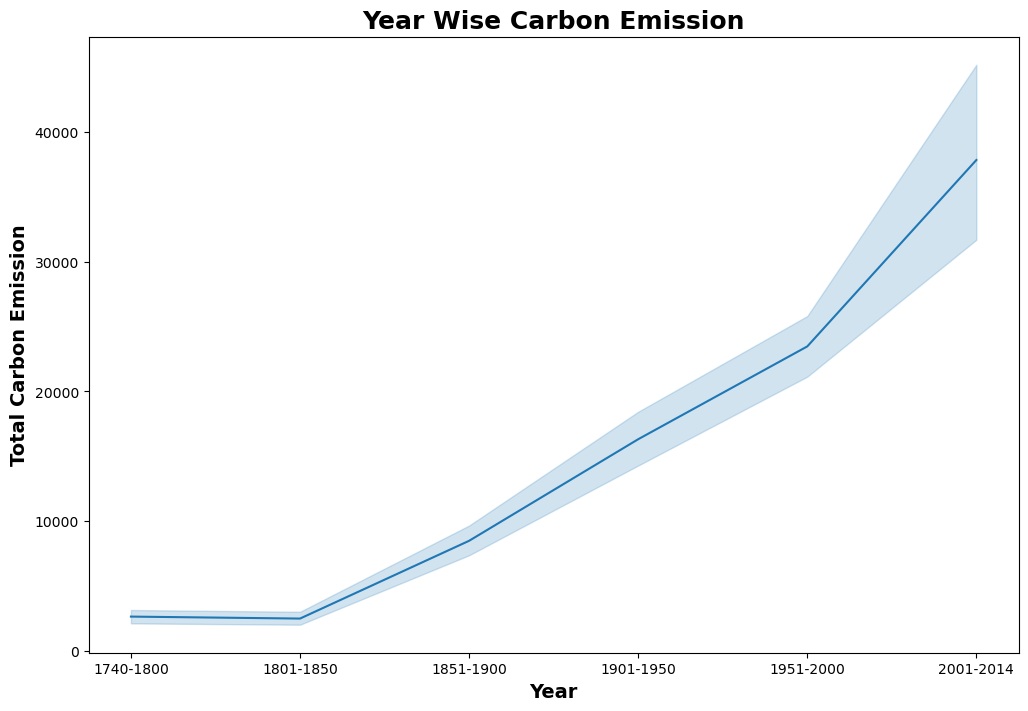

In [22]:
df1 = df.copy()

# Defining the year ranges
year_ranges = [(1740, 1800), (1801, 1850), (1851, 1900), (1901, 1950), (1951, 2000), (2001, 2015)]

# Labels of Year ranges
labels = ['1740-1800', '1801-1850', '1851-1900', '1901-1950', '1951-2000', '2001-2014']

# Adding a new column to the dataframe by grouping year ranges
df1['Year_Range'] = pd.cut(df['Year'], bins=[range[0] for range in year_ranges] + [year_ranges[-1][1]], labels=labels)

plt.figure(figsize=(12,8))
sns.lineplot(x='Year_Range',y='Total_emission',data=df1)
plt.title("Year Wise Carbon Emission",fontsize=18,fontweight='bold')
plt.xlabel('Year',fontsize=14,fontweight='bold')
plt.ylabel('Total Carbon Emission',fontsize=14,fontweight='bold')
plt.show()

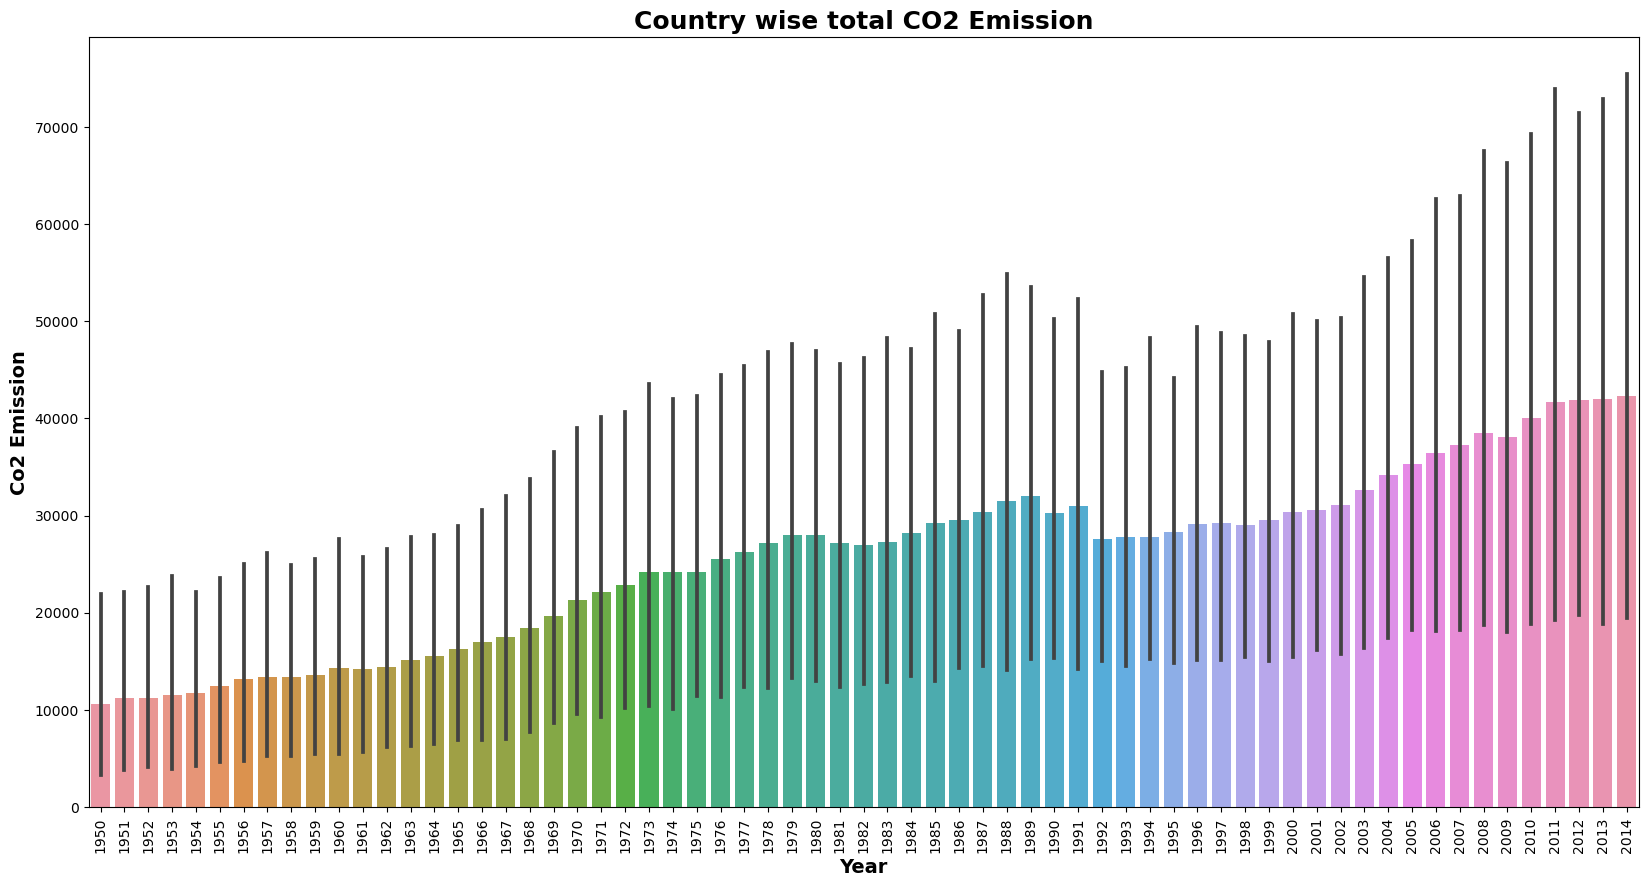

In [23]:
# creating new data frame for clear visualization
df2 = df[df['Year']>=1950]

plt.figure(figsize=(20,10))
sns.barplot(x='Year',y='Total_emission',data=df2)
plt.xticks(rotation=90)
plt.xlabel("Year",fontsize=14,fontweight='bold')
plt.ylabel("Co2 Emission",fontsize=14,fontweight='bold')
plt.title("Country wise total CO2 Emission",fontsize=18,fontweight='bold')
plt.show()

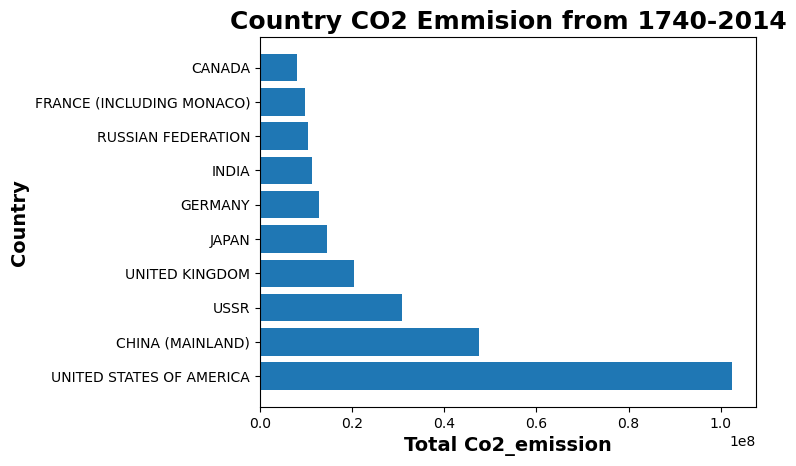

In [24]:
# Group the data by country and calculate the total CO2 emissions for each country
df_country_co2 = df.groupby('Country')['Total_emission'].sum().reset_index()

df_country_co2 = df_country_co2.sort_values('Total_emission',ascending=False)

# Select the top ten countries
df_country_co2 = df_country_co2.head(10)

# Plot line graph of CO2 emissions
plt.barh(df_country_co2['Country'], df_country_co2['Total_emission'])

# Add labels and title
plt.xlabel('Total Co2_emission',fontsize=14,fontweight='bold')
plt.ylabel('Country',fontsize=14,fontweight='bold')
plt.title('Country CO2 Emmision from 1740-2014',fontsize=18,fontweight='bold')
plt.show()

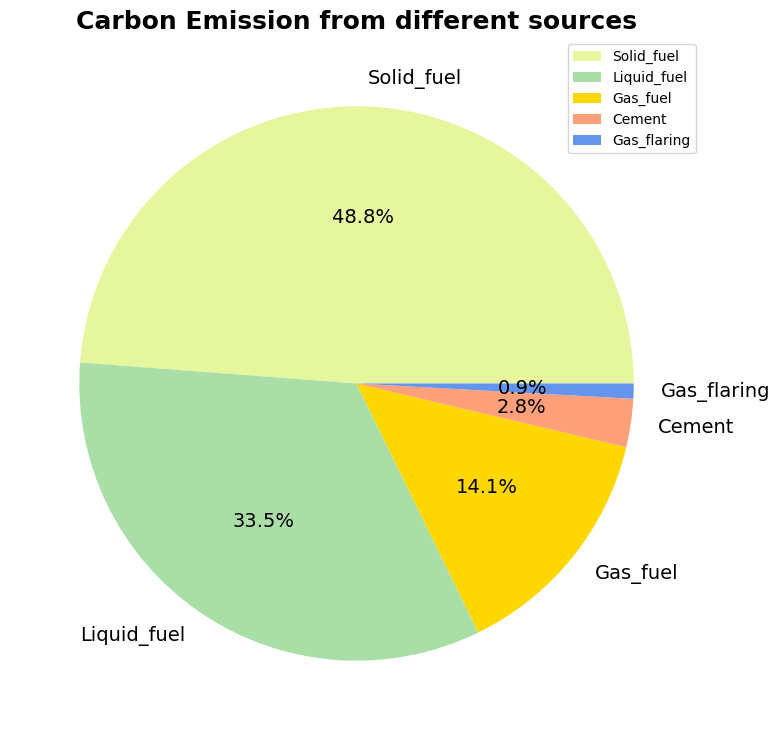

In [25]:
df2 = df[['Solid_fuel','Liquid_fuel','Gas_fuel','Cement','Gas_flaring']]
count = df2.sum()
label=['Solid_fuel','Liquid_fuel','Gas_fuel','Cement','Gas_flaring']
colors = ['#E6F69D', '#AADEA7', '#FFD700', '#FFA07A', '#6495ED']
plt.figure(figsize=(9,9))
plt.title("Carbon Emission from different sources",fontsize=18,fontweight='bold')
plt.pie(count,autopct='%1.1f%%',labels=label,textprops={"fontsize":14},colors=colors)
plt.legend(loc='upper right')
plt.show()

In [26]:
le=LabelEncoder()
df['Country'] = le.fit_transform(df['Country'])
df

,Year,Country,Total_emission,Solid_fuel,Liquid_fuel,Gas_fuel,Cement,Gas_flaring,Per_capita,Bunker_fuels
0,2014,0,2675.0,1194.0,1393.0,74.0,14.0,0.0,0.08,9.0
1,2014,1,1559.0,191.0,1053.0,16.0,299.0,0.0,0.54,23.0
2,2014,2,39651.0,149.0,14422.0,20151.0,2856.0,2073.0,1.02,581.0
3,2014,3,126.0,0.0,126.0,0.0,0.0,0.0,1.74,0.0
4,2014,4,9480.0,0.0,5310.0,158.0,340.0,3672.0,0.39,509.0
...,...,...,...,...,...,...,...,...,...,...
17227,1755,239,2555.0,2555.0,0.0,0.0,0.0,0.0,0.00,0.0
17228,1754,239,2554.0,2554.0,0.0,0.0,0.0,0.0,0.00,0.0
17229,1753,239,2553.0,2553.0,0.0,0.0,0.0,0.0,0.00,0.0
17230,1752,239,2553.0,2553.0,0.0,0.0,0.0,0.0,0.00,0.0


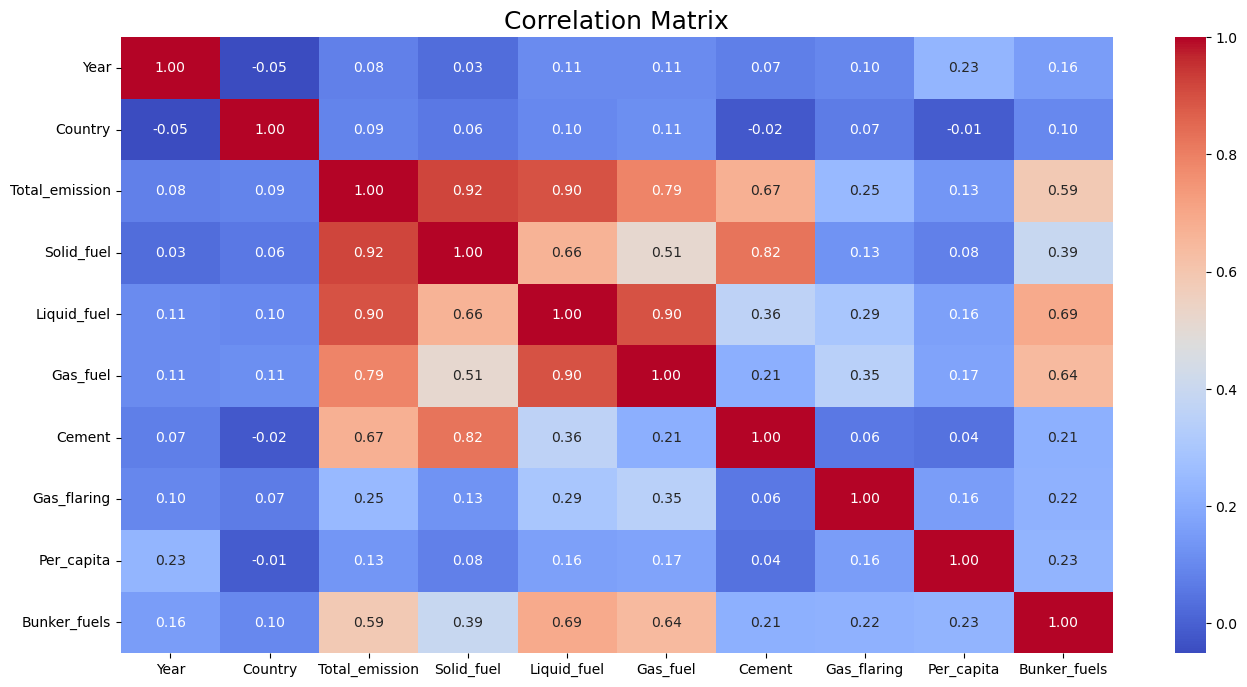

In [27]:
corr_matrix = df.corr()
plt.figure(figsize=(16,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix',fontsize=18)
plt.show()

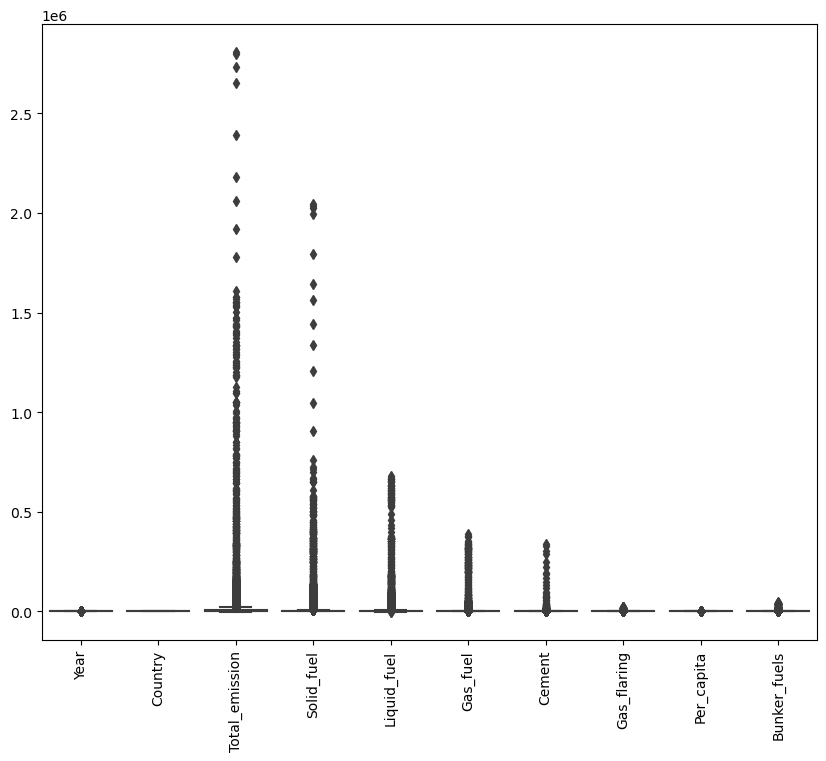

In [28]:
#Plot box plots for checking outliers
plt.figure(figsize=(10, 8))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.show()

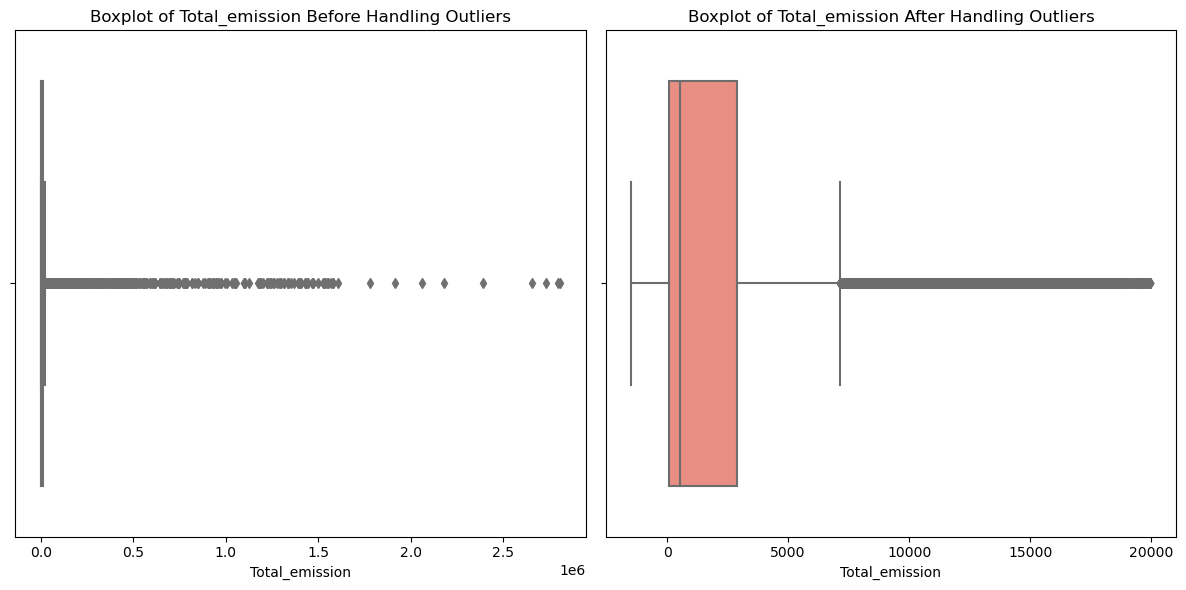

In [29]:
threshold = 1.5
Q1 = df['Total_emission'].quantile(0.25)
Q3 = df['Total_emission'].quantile(0.75)
IQR = Q3-Q1
lower_bound = Q1 - threshold * IQR
upper_bound = Q3 + threshold * IQR
df_nooutliers = df[(df['Total_emission'] >= lower_bound) & (df['Total_emission'] <= upper_bound)]

column = 'Total_emission'
# Visualize the data before handling outliers
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x=df[column], color='skyblue')
plt.title(f'Boxplot of {column} Before Handling Outliers')
plt.xlabel(column)

# Visualize the data after handling outliers
plt.subplot(1, 2, 2)
sns.boxplot(x=df_nooutliers[column], color='salmon')
plt.title(f'Boxplot of {column} After Handling Outliers')
plt.xlabel(column)

plt.tight_layout()
plt.show()

In [30]:
df.shape

(17232, 10)

In [31]:
df_nooutliers.shape

(14735, 10)

In [32]:
x = df_nooutliers.drop(columns=['Total_emission'])
x

,Year,Country,Solid_fuel,Liquid_fuel,Gas_fuel,Cement,Gas_flaring,Per_capita,Bunker_fuels
0,2014,0,1194.0,1393.0,74.0,14.0,0.0,0.08,9.0
1,2014,1,191.0,1053.0,16.0,299.0,0.0,0.54,23.0
3,2014,3,0.0,126.0,0.0,0.0,0.0,1.74,0.0
4,2014,4,0.0,5310.0,158.0,340.0,3672.0,0.39,509.0
5,2014,5,0.0,39.0,0.0,0.0,0.0,2.66,0.0
...,...,...,...,...,...,...,...,...,...
17227,1755,239,2555.0,0.0,0.0,0.0,0.0,0.00,0.0
17228,1754,239,2554.0,0.0,0.0,0.0,0.0,0.00,0.0
17229,1753,239,2553.0,0.0,0.0,0.0,0.0,0.00,0.0
17230,1752,239,2553.0,0.0,0.0,0.0,0.0,0.00,0.0


In [33]:
y = df_nooutliers['Total_emission']
y

0        2675.0
1        1559.0
3         126.0
4        9480.0
5          39.0
          ...  
17227    2555.0
17228    2554.0
17229    2553.0
17230    2553.0
17231    2552.0
Name: Total_emission, Length: 14735, dtype: float64

In [34]:
scaler=MinMaxScaler()
X_scaled=scaler.fit_transform(x)
X_scaled

array([[1.00000000e+00, 0.00000000e+00, 6.61194943e-02, ...,
        0.00000000e+00, 1.62950257e-02, 2.13194362e-04],
       [1.00000000e+00, 3.92156863e-03, 1.49877651e-02, ...,
        0.00000000e+00, 2.61578045e-02, 5.44830037e-04],
       [1.00000000e+00, 1.17647059e-02, 5.25081566e-03, ...,
        0.00000000e+00, 5.18867925e-02, 0.00000000e+00],
       ...,
       [7.60456274e-03, 9.37254902e-01, 1.35399674e-01, ...,
        0.00000000e+00, 1.45797599e-02, 0.00000000e+00],
       [3.80228137e-03, 9.37254902e-01, 1.35399674e-01, ...,
        0.00000000e+00, 1.45797599e-02, 0.00000000e+00],
       [0.00000000e+00, 9.37254902e-01, 1.35348695e-01, ...,
        0.00000000e+00, 1.45797599e-02, 0.00000000e+00]])

In [35]:
X_train,X_test,y_train,y_test=train_test_split(X_scaled,y,test_size=0.30,random_state=10)

In [36]:
rfg=RandomForestRegressor(random_state=1)
rfg.fit(X_train,y_train)
y_pred=rfg.predict(X_test)
y_pred

array([10018.11,    82.04, 18743.63, ...,  3999.23,   224.18,  5887.1 ])

In [37]:
print("r2_score:",r2_score(y_test,y_pred)*100)

r2_score: 99.57986176925615
